In [1]:
import pandas as pd
import numpy as np
import networkx as nx

from pylab import rcParams

In [2]:
node_types = {
    'job': 'RQ',
    'job_level': 'JL',
    'job_type': 'JT',
}

In [3]:
G = nx.Graph()

In [4]:
df = pd.read_csv('../../data/disney/imagineering_jobs.csv')
df['level'] = df.level.fillna('').map(lambda x: x.split(', '))
df['job_type'] = df.job_type.fillna('').map(lambda x: x.split(', '))

df.head(n=3)

,cat_id,job_id,title,date,brand,location,req_id,url,close,full_title,level,job_type
0,391,30172889184,Software Development Mgr,2022-05-31,Walt Disney Imagineering,"Orlando, Florida, United States / Lake Buena V...",941484BR,https://jobs.disneycareers.com/job/orlando/sof...,-,Software Development Manager,[MANAGER],[SOFTWARE]
1,391,30224999136,Show Systems Engineering Senior,2022-06-01,Walt Disney Imagineering,"Glendale, California, United States / Glendale...",945616BR,https://jobs.disneycareers.com/job/glendale/sh...,-,Show Systems Engineering Senior,[SENIOR],[SYSTEMS]
2,391,30518402336,PH-Asst Project Mgr,2022-06-06,Walt Disney Imagineering,"Orlando, Florida, United States / Lake Buena V...",993386BR,https://jobs.disneycareers.com/job/orlando/ph-...,-,Assistant Project Manager (Project Hire),"[PROJECT-HIRE, MANAGER]",[]


In [5]:
label = node_types['job']

for id, date, close in df[['req_id', 'date', 'close']].values:
    attrs = { 'start_date': date }
    if close != '-':
        attrs['close_date'] = close
    
    G.add_node(f'{label} - {id}', **attrs)

In [6]:
def add_descriptors(descriptors, label):
    keywords = set()
    for terms in descriptors:
      for term in terms:
          if term == '':
              continue
            
          keywords.add(term)

    for keyword in list(keywords):
        G.add_node(f'{label} - {keyword}')

In [7]:
add_descriptors(df[df.level.map(len) > 0].level, node_types['job_level'])
add_descriptors(df[df.job_type.map(len) > 0].job_type, node_types['job_type'])

In [8]:
def connect_descriptors_to_parent(vals, p1, p2):
    for id, terms in vals:
        for keyword in terms:
            if keyword == '':
                continue
            
            G.add_edge(f'{p1} - {id}', f'{p2} - {keyword}')

In [9]:
connect_descriptors_to_parent(df[df.level.map(len) > 0][['req_id', 'level']].values, node_types['job'], node_types['job_level'])
connect_descriptors_to_parent(df[df.job_type.map(len) > 0][['req_id', 'job_type']].values, node_types['job'], node_types['job_type'])

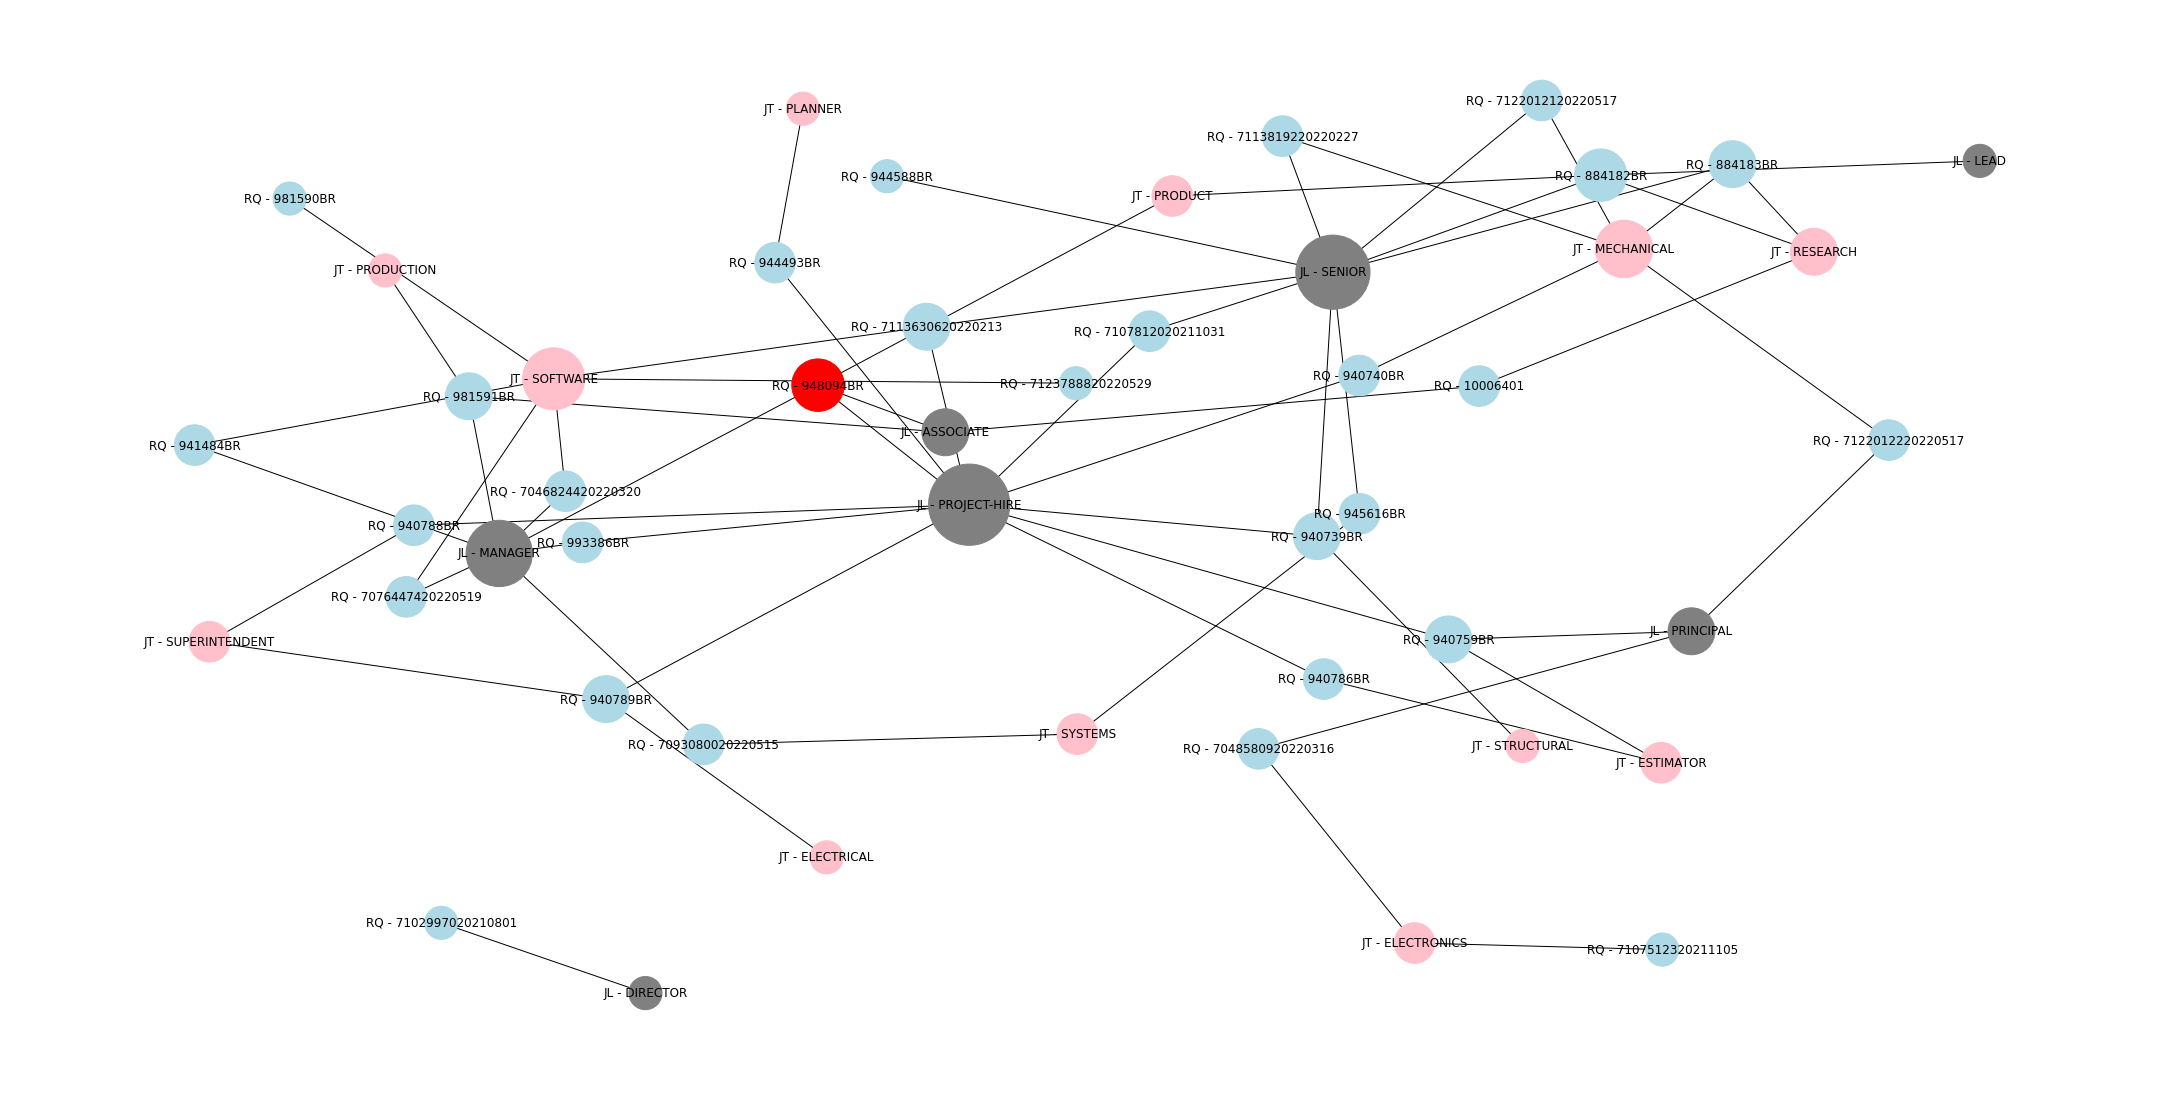

In [12]:
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = 30, 15

pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))

def get_color(node, items):
    if node.startswith(node_types['job']):
        if 'close_date' in items:
            return 'red'
        return 'lightblue'

    if node.startswith(node_types['job_level']):
        return 'gray'

    if node.startswith(node_types['job_type']):
        return 'pink'

    return 'white'

colors = [ get_color(node, items) for node, items in G.nodes(data=True) ]

d = dict(G.degree)

nx.draw(
    G,
    pos,
    with_labels=True,
    nodelist=d,
    node_size=[(d[k]+1)*550 for k in d],
    node_color=colors,
)